<a href="https://colab.research.google.com/github/Aman2000102/machineLearning/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download -d anaselmasry/covid19normalpneumonia-ct-images

Dataset URL: https://www.kaggle.com/datasets/anaselmasry/covid19normalpneumonia-ct-images
License(s): copyright-authors
 98% 913M/936M [00:04<00:00, 277MB/s]
100% 936M/936M [00:04<00:00, 221MB/s]


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
import shutil
import random
import zipfile

In [ ]:
# Path to the zip file
path = "covid19normalpneumonia-ct-images.zip"
# Class directories within the zip
classesPath = ['Normal_CT', 'pneumonia_CT']

# Split ratio
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Extract the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Update path to point to the extracted directory
extracted_path = "/content/"

# Create a dictionary to hold the number of files in each class
class_file_counts = {}

# First, gather the number of files in each class to find the minority class
for cls in classesPath:
    src = os.path.join(extracted_path, cls)
    allFileNames = os.listdir(src)
    class_file_counts[cls] = len(allFileNames)

# Find the minimum file count across all classes (the minority class)
min_files = min(class_file_counts.values())

# Ensure the output directories exist
for cls in classesPath:
    os.makedirs(os.path.join('./train/', cls), exist_ok=True)
    os.makedirs(os.path.join('./val/', cls), exist_ok=True)
    os.makedirs(os.path.join('./test/', cls), exist_ok=True)

    # Define the source path for class images
    src = os.path.join(extracted_path, cls)

    # Get list of all image file names in the class directory
    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)  # Shuffle the file list to ensure randomness

    # Limit the file count to match the minority class
    balanced_FileNames = allFileNames[:min_files]  # Undersample to match the minority class

    # Calculate the split sizes
    total_files = len(balanced_FileNames)
    train_count = int(train_ratio * total_files)
    val_count = int(val_ratio * total_files)
    test_count = total_files - train_count - val_count  # Remaining files go to the test set

    # Split the filenames into training, validation, and test sets
    train_FileNames = balanced_FileNames[:train_count]
    val_FileNames = balanced_FileNames[train_count:train_count + val_count]
    test_FileNames = balanced_FileNames[train_count + val_count:]

    # Print statistics for each class
    print(f'Total {cls} after balancing: {total_files}')
    print(f'Training: {len(train_FileNames)}')
    print(f'Validation: {len(val_FileNames)}')
    print(f'Testing: {len(test_FileNames)}\n')

    # Copy files to their respective directories
    for name in train_FileNames:
        shutil.copy(os.path.join(src, name), os.path.join('./train/', cls))

    for name in val_FileNames:
        shutil.copy(os.path.join(src, name), os.path.join('./val/', cls))

    for name in test_FileNames:
        shutil.copy(os.path.join(src, name), os.path.join('./test/', cls))

Total Normal_CT after balancing: 2119
Training: 1271
Validation: 423
Testing: 425

Total pneumonia_CT after balancing: 2119
Training: 1271
Validation: 423
Testing: 425



In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to directories
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

# Data Augmentation for Training Set (Preprocessing)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.1,
    fill_mode='nearest'
)

# Validation and Test sets should not have augmentation, only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators for each dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    color_mode="rgb",
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    seed=90
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    color_mode="rgb",
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    seed=90
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    color_mode="rgb",
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    seed=90
)

# EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

# Fetch the entire training dataset from the generator
X_train_full = []
y_train_full = []

for i in range(train_generator.__len__()):
    X_batch, y_batch = train_generator.__getitem__(i)
    X_train_full.append(X_batch)
    y_train_full.append(y_batch)

X_train_full = np.concatenate(X_train_full, axis=0)
y_train_full = np.concatenate(y_train_full, axis=0)

# Split the data into training and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Class weights to handle class imbalance
class_weights_dict = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights_dict))

# Initialize ResNet50 without the top layers (pre-trained on ImageNet)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=X_train.shape[1:])

# Unfreeze the last few layers of ResNet50 for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Add GlobalAveragePooling and output layers with Dropout
x = GlobalAveragePooling2D(name="GlobalAveragePooling_1")(base_model.output)
x = Dropout(0.5)(x)  # Add dropout layer to reduce overfitting
y_hat = Dense(1, activation='sigmoid', name="Output")(x)

model_ResNet50 = Model(inputs=base_model.input, outputs=y_hat)

# Compile the model with Adam optimizer and Focal Loss
optimizer = Adam(learning_rate=1e-4)  # Use a lower learning rate for fine-tuning
loss = BinaryFocalCrossentropy(gamma=2.0)  # Focal loss to handle class imbalance
model_ResNet50.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model on the training set with class weights
history_ResNet50 = model_ResNet50.fit(
    X_train_full, y_train_full,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val,y_val),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights_dict  # Add class weights here
)



# Evaluate on the validation set
val_preds = model_ResNet50.predict(X_val)
val_preds_binary = (val_preds > 0.5).astype(int)

accuracy = accuracy_score(y_val, val_preds_binary)
precision = precision_score(y_val, val_preds_binary)
recall = recall_score(y_val, val_preds_binary)
f1 = f1_score(y_val, val_preds_binary)

print(f'Validation Set - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}')


# Prepare the full test dataset
X_test_full = []
y_test_full = []

for i in range(test_generator.__len__()):
    X_batch, y_batch = test_generator.__getitem__(i)
    X_test_full.append(X_batch)
    y_test_full.append(y_batch)

X_test_full = np.concatenate(X_test_full, axis=0)
y_test_full = np.concatenate(y_test_full, axis=0)

# Predict on the full test set
test_preds = model_ResNet50.predict(X_test_full)

test_preds_binary = (test_preds > 0.5).astype(int)

test_accuracy = accuracy_score(y_test_full, test_preds_binary)
test_precision = precision_score(y_test_full, test_preds_binary)
test_recall = recall_score(y_test_full, test_preds_binary)
test_f1 = f1_score(y_test_full, test_preds_binary)

print(f'\nTest Set - Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1-Score: {test_f1}')


Found 2542 images belonging to 2 classes.
Found 846 images belonging to 2 classes.
Found 850 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 114s 629ms/step - accuracy: 0.6704 - loss: 0.2939 - val_accuracy: 0.5069 - val_loss: 0.5977 - learning_rate: 1.0000e-04
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 69s 119ms/step - accuracy: 0.9022 - loss: 0.0765 - val_accuracy: 0.5069 - val_loss: 0.6861 - learning_rate: 1.0000e-04
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.9522 - loss: 0.0333 - val_accuracy: 0.5069 - val_loss: 0.5607 - learning_rate: 1.0000e-04
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.9801 - loss: 0.0153 - val_accuracy: 0.5108 - val_loss: 0.5505 - learning_rate: 1.0000e-04
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.9806 - loss: 0.0124 - val_accuracy: 0.5010 - val_loss: 0.5341 - learning_rate: 1.0000e-04
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 10

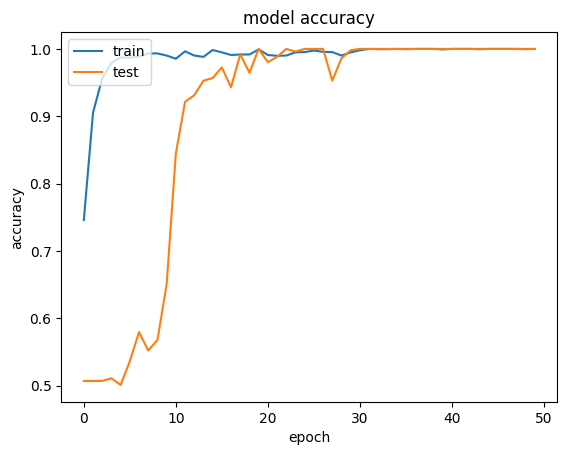

In [ ]:
# Plot training and validation accuracy

plt.plot(history_ResNet50.history['accuracy'])
plt.plot(history_ResNet50.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step


<Figure size 800x600 with 0 Axes>

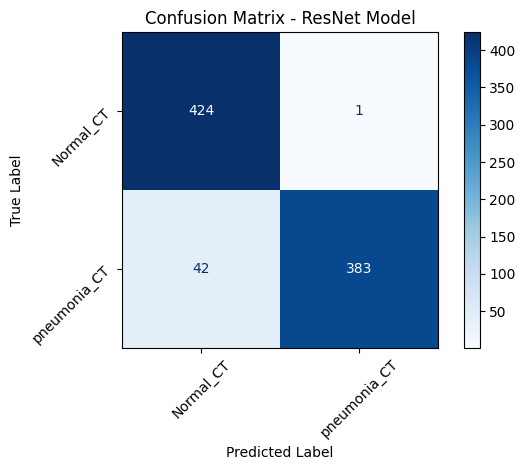

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate model on test data
predictions = model_ResNet50.predict(test_generator)
y_pred = (predictions > 0.5).astype(int).ravel()  # Convert probabilities to class labels (0 or 1)

# True labels
y_true = test_generator.classes  # Assuming test_generator has the true labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - ResNet Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_ResNet50.save('/content/drive/MyDrive/Colab Notebooks/ResNet50.h5')

In [ ]:
#Applying XAI techniques on ResNet50 model

<ipython-input-13-255fc1d7bcda>:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap(cmap)


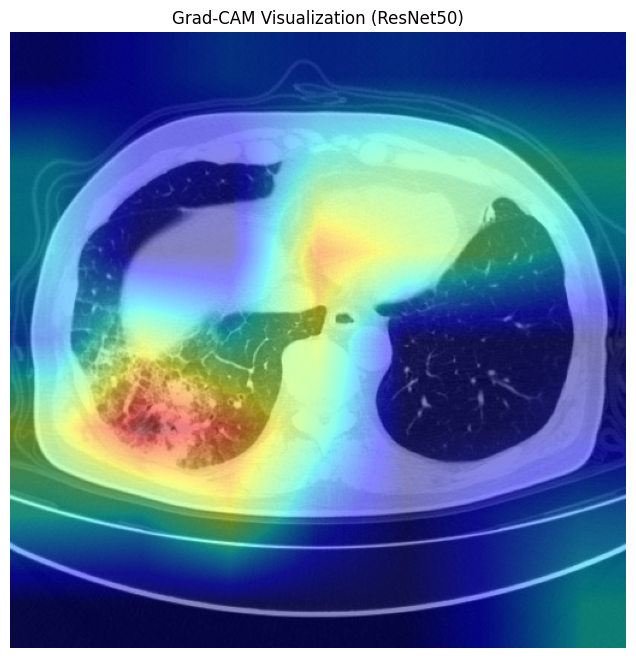

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the ResNet50 model
model = ResNet50(weights="imagenet")

# Function to preprocess input image
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Grad-CAM function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute the gradients of the top predicted class with respect to the output feature map
    grads = tape.gradient(class_channel, conv_outputs)

    # Compute the mean intensity of the gradients for each feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each feature map by its corresponding gradient intensity
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Apply ReLU to the heatmap and normalize
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + tf.keras.backend.epsilon())
    return heatmap.numpy()

# Function to overlay the heatmap on the original image
def overlay_heatmap(heatmap, img_path, alpha=0.4, cmap="jet"):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    # Resize heatmap to match image dimensions
    heatmap = np.uint8(255 * heatmap)
    heatmap = tf.image.resize(heatmap[..., np.newaxis], (img.shape[0], img.shape[1])).numpy()
    heatmap = heatmap[:, :, 0]

    # Apply colormap
    jet = plt.cm.get_cmap(cmap)
    colored_heatmap = jet(heatmap / 255.0)[:, :, :3]
    colored_heatmap = np.uint8(255 * colored_heatmap)

    # Overlay the heatmap on the image
    superimposed_img = img * (1 - alpha) + colored_heatmap * alpha
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    return tf.keras.preprocessing.image.array_to_img(superimposed_img)

# Test with an example image
img_path = "/content/test/pneumonia_CT/105 (30).jpg"
img_array = preprocess_image(img_path)

# Get Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block3_out")

# Overlay heatmap on image
superimposed_img = overlay_heatmap(heatmap, img_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img)
plt.axis("off")
plt.title("Grad-CAM Visualization (ResNet50)")
plt.show()


<ipython-input-13-255fc1d7bcda>:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap(cmap)


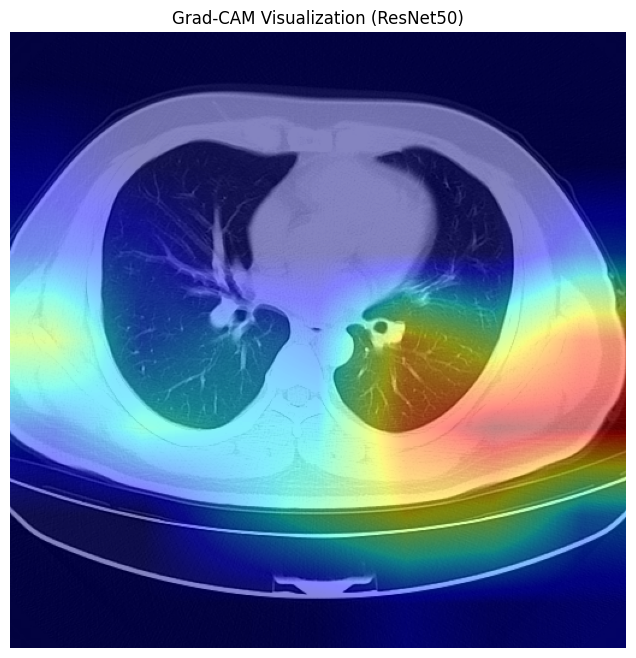

In [ ]:
img_path = "/content/test/Normal_CT/23985k (28).jpg"
img_array = preprocess_image(img_path)

# Get Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block3_out")

# Overlay heatmap on image
superimposed_img = overlay_heatmap(heatmap, img_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img)
plt.axis("off")
plt.title("Grad-CAM Visualization (ResNet50)")
plt.show()


<ipython-input-20-0e452a1897e9>:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


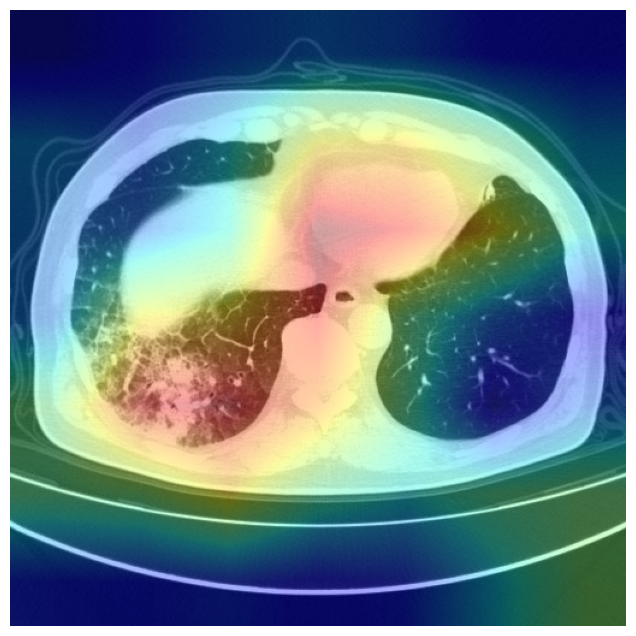

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the ResNet50 model
# Ensure the model ends with a Global Average Pooling (GAP) layer
model = ResNet50(weights="imagenet")

# Function to preprocess input image
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Function to compute Class Activation Mapping (CAM)
def compute_cam(img_array, model, last_conv_layer_name, class_idx=None):
    # Create a model that maps input image to the activations of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_model = tf.keras.models.Model(model.input, last_conv_layer.output)

    # Get the classification layer weights
    classifier_weights = model.layers[-1].get_weights()[0]  # Final dense layer weights

    # Compute the feature maps and predictions
    feature_maps = last_conv_model(img_array)
    predictions = model(img_array)

    if class_idx is None:
        class_idx = np.argmax(predictions[0])

    # Get the weights for the specific class
    class_weights = classifier_weights[:, class_idx]

    # Compute the weighted sum of feature maps
    cam = tf.reduce_sum(feature_maps[0] * class_weights, axis=-1)

    # Normalize CAM
    cam = tf.maximum(cam, 0)  # ReLU operation
    cam = cam / tf.reduce_max(cam)
    return cam.numpy()

# Function to overlay CAM on original image
def overlay_cam(cam, img_path, alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    # Resize CAM to the size of the original image
    cam = np.uint8(255 * cam)
    cam = tf.image.resize(np.expand_dims(cam, axis=-1), (img.shape[0], img.shape[1])).numpy()
    cam = np.uint8(cam[:, :, 0])

    # Create a colored heatmap
    jet = plt.cm.get_cmap("jet")
    jet_heatmap = jet(np.arange(256))[:, :3]
    jet_heatmap = np.uint8(jet_heatmap * 255)
    colored_heatmap = jet_heatmap[cam]

    # Overlay the heatmap on the image
    superimposed_img = colored_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

# Test with an example image
img_path = "/content/test/pneumonia_CT/105 (30).jpg"
img_array = preprocess_image(img_path)

# Get CAM heatmap
cam = compute_cam(img_array, model, last_conv_layer_name="conv5_block3_out")

# Overlay CAM on image
superimposed_img = overlay_cam(cam, img_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img)
plt.axis("off")
plt.show()


<ipython-input-20-0e452a1897e9>:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


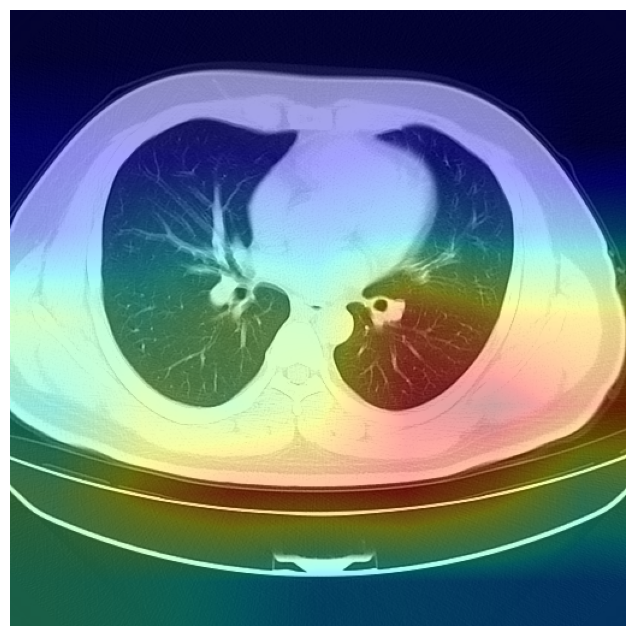

In [ ]:
img_path = "/content/test/Normal_CT/23985k (28).jpg"
img_array = preprocess_image(img_path)

# Get CAM heatmap
cam = compute_cam(img_array, model, last_conv_layer_name="conv5_block3_out")

# Overlay CAM on image
superimposed_img = overlay_cam(cam, img_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img)
plt.axis("off")
plt.show()

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=fab2d436bdb76fb089f0ce206122b421506128fa987b3ec87a1e550e273c1d00
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


102869336/102869336 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Predicted: [('n03584254', 'iPod', 0.24566872), ('n03447721', 'gong', 0.095771074), ('n04192698', 'shield', 0.068115726)]


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

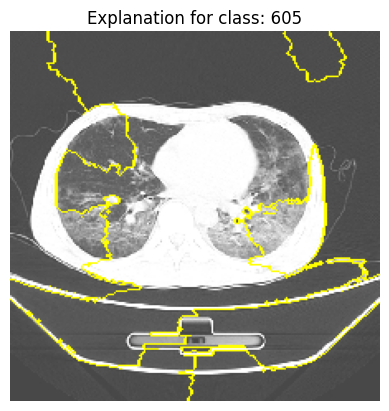

In [ ]:
#Applying LIME XAI technique

import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries

def explain_image_with_lime(model, img_path):
    """
    Explains the prediction of a model on a given image using LIME.

    Parameters:
    - model: A pre-trained model that will be used to make predictions.
    - img_path: The path to the image to be explained.

    Returns:
    - None: The function displays the image with LIME explanations.
    """

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))  # Adjust the target size according to your model
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = model.preprocess_input(img_array)  # Replace with your model's preprocess function if needed

    # Get the model's prediction
    preds = model.predict(img_array)
    print('Predicted:', model.decode_predictions(preds, top=3)[0])  # Adjust this according to your model

    # Initialize LIME image explainer
    explainer = lime_image.LimeImageExplainer()

    # Explain the prediction
    explanation = explainer.explain_instance(
        img_array[0].astype('double'),
        model.predict,
        top_labels=5,
        hide_color=0,
        num_samples=1000
    )

    # Get the explanation for the top predicted label
    top_label = np.argmax(preds)
    temp, mask = explanation.get_image_and_mask(
        top_label,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )

    # Display the image with boundaries
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f"Explanation for class: {top_label}")
    plt.axis('off')
    plt.show()

# Example usage:
if __name__ == "__main__":
    from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input, decode_predictions
    model = ResNet50V2(weights='imagenet')
    model.preprocess_input = preprocess_input  # Add preprocess and decode functions to the model object
    model.decode_predictions = decode_predictions

    img_path = '/content/test/pneumonia_CT/200 (43).jpg'

     # Call the function to explain the image
    explain_image_with_lime(model, img_path)
